In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
def get_infractions(record):
    infraction_counts = {
        'collisions_layout': 0,
        'collisions_pedestrian': 0,
        'collisions_vehicle': 0,
        'outside_route_lanes': 0,
        'red_light': 0,
        'route_dev': 0,
        'route_timeout': 0,
        'stop_infraction': 0,
        'vehicle_blocked': 0
    }
    for key, value in record["infractions"].items():
        infraction_counts[key] += len(value)
    return infraction_counts

In [3]:
def get_route_df(exp_path):
    # Define the column names
    columns = [
        'model_name', 'model_number', 'run', 'route', 'score_composed', 'score_penalty', 'score_route',
        'collisions_layout', 'collisions_pedestrian', 'collisions_vehicle', 'outside_route_lanes',
        'red_light', 'route_dev', 'route_timeout', 'stop_infraction', 'vehicle_blocked'
    ]

    # Create an empty DataFrame with the specified columns
    df = pd.DataFrame(columns=columns)

    for run in os.listdir(exp_path):
        for model in os.listdir(f"{exp_path}/{run}"):
            model_name = model.split("_mn_")[0]
            model_number = model.split("_mn_")[1]
            results_path = f"{exp_path}/{run}/{model}/results.json"
            # Read json file
            with open(results_path) as f:
                results = json.load(f)
            if len(results["values"]) == 0:
                print(f"No results in {results_path}")
                continue
            for idx in range(10):
                record = results['_checkpoint']['records'][idx]
                infraction_counts = get_infractions(record)
                scores = record["scores"]
                
                row = [model_name, model_number, run, idx]
                row.extend(list(scores.values()))
                row.extend(list(infraction_counts.values()))
                df.loc[len(df)] = row
    return df

In [4]:
def plot_dist(stop_inf_no_pl, stop_inf_pl):
    data = pd.DataFrame({
        'No Pl': stop_inf_no_pl,
        'Pl': stop_inf_pl
    })
    # Plotting the histograms
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(stop_inf_no_pl, kde=True, color='blue', label='No Pl', bins=10)
    sns.histplot(stop_inf_pl, kde=True, color='red', label='Pl', bins=10)
    plt.legend()
    plt.title('Histogram of No Pl and Pl')

    # Plotting the box plots
    plt.subplot(1, 2, 2)
    sns.boxplot(data=data)
    plt.title('Box Plot of No Pl and Pl')

    plt.tight_layout()
    plt.show()

In [5]:
def ttest(stop_inf_no_pl, stop_inf_pl, print_results=False):
    t_statistic, p_value = ttest_ind(stop_inf_no_pl, stop_inf_pl)
    data = pd.DataFrame({
        'No Pl': stop_inf_no_pl,
        'Pl': stop_inf_pl
    })
    aux = data.aggregate(['mean', 'std'])
    improvement = (aux["No Pl"]["mean"] - aux["Pl"]["mean"]) / aux["No Pl"]["mean"] * 100
    
    if print_results:
        print(f"t-statistic: {t_statistic}")
        print(f"P-value: {p_value}")
        if p_value < 0.05:
            print("There is a significant difference!")
        print("---")
        print(f"No Pl: {aux['No Pl']['mean']}")
        print(f"Pl: {aux['Pl']['mean']}")
        print(f"Improvement: {improvement:.2f}%")
    
    return t_statistic, p_value, improvement

# Table

In [6]:
attributes = ["score_composed", "collisions_layout", "collisions_pedestrian", "collisions_vehicle", "outside_route_lanes", "red_light", "route_dev", "route_timeout", "stop_infraction", "vehicle_blocked"]
avgs = {
    "pl": {},
    "nopl": {}
}
for att in attributes:
    avgs["pl"][att] = 0
    avgs["nopl"][att] = 0

results_df = pd.DataFrame(columns=["Epochs", "\\approach", *attributes])
studies = ["5e5_5e", "5e5_10e", "5e5_15e"]
base_path = "./results_summary/"
for study in studies:
    n_epochs = int(study.split("_")[1].split("e")[0])
    model_df = {}
    for model_type in ["pl", "nopl"]:
        study_path = base_path + f"final_{model_type}_5e5_{n_epochs}e"
        route_df = get_route_df(study_path)
        model_df[model_type] = route_df.groupby(['model_name', 'model_number', 'run']).agg(['mean'])
    row1 = [n_epochs, "\\cmark"]
    row2 = [n_epochs, "\\xmark"]
    for att in attributes:
        pl_data = model_df["pl"][att]["mean"].tolist()
        nopl_data = model_df["nopl"][att]["mean"].tolist()
        statistics, p_value, improvement = ttest(nopl_data, pl_data)
        s1 = f"{model_df['pl'][att]['mean'].mean():.2f} $\\pm$ {model_df['pl'][att]['mean'].std():.2f}"
        avgs["pl"][att] += model_df['pl'][att]['mean'].mean()
        s2 = f"{model_df['nopl'][att]['mean'].mean():.2f} $\\pm$ {model_df['nopl'][att]['mean'].std():.2f}"
        avgs["nopl"][att] += model_df['nopl'][att]['mean'].mean()
        if att == "score_composed":
            improvement = improvement * -1
        if improvement > 0:
            s1 = "\\textbf{" + s1 + "}"
        else:
            s2 = "\\textbf{" + s2 + "}"                
        if p_value < 0.05:
            if improvement > 0:
                s1 = "\\underline{" + s1 + "}"
            else:
                s2 = "\\underline{" + s2 + "}"
        row1.append(s1)
        row2.append(s2)
    results_df.loc[len(results_df)] = row1
    results_df.loc[len(results_df)] = row2
for att in attributes:
    avgs["pl"][att] /= len(studies)
    avgs["nopl"][att] /= len(studies)
# Summary
s1 = [f"{avgs['pl'][att]:.2f}" for att in attributes]
row1 = ["Avg", "\\cmark"] + ["\\multicolumn{1}{c}{" + s1[idx] + "}" for idx in range(len(attributes))]
results_df.loc[len(results_df)] = row1
s2 = [f"{avgs['nopl'][att]:.2f}" for att in attributes]
row2 = ["Avg", "\\xmark"] + ["\\multicolumn{1}{c}{" + s2[idx] + "}" for idx in range(len(attributes))]
results_df.loc[len(results_df)] = row2

/home/ft8bn/sg/T4PC/.t4pc/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/ft8bn/sg/T4PC/.t4pc/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


In [7]:
results_df

,Epochs,\approach,score_composed,collisions_layout,collisions_pedestrian,collisions_vehicle,outside_route_lanes,red_light,route_dev,route_timeout,stop_infraction,vehicle_blocked
0,5,\cmark,\textbf{81.09 $\pm$ 6.58},0.00 $\pm$ 0.00,0.00 $\pm$ 0.00,0.13 $\pm$ 0.17,0.00 $\pm$ 0.00,0.04 $\pm$ 0.05,0.00 $\pm$ 0.00,0.01 $\pm$ 0.03,\underline{\textbf{0.54 $\pm$ 0.20}},0.09 $\pm$ 0.09
1,5,\xmark,79.20 $\pm$ 4.34,\textbf{0.00 $\pm$ 0.00},\textbf{0.00 $\pm$ 0.00},\textbf{0.12 $\pm$ 0.14},\textbf{0.00 $\pm$ 0.00},\textbf{0.04 $\pm$ 0.06},\textbf{0.00 $\pm$ 0.00},\textbf{0.00 $\pm$ 0.00},0.98 $\pm$ 0.22,\underline{\textbf{0.00 $\pm$ 0.00}}
2,10,\cmark,\underline{\textbf{81.98 $\pm$ 5.16}},0.00 $\pm$ 0.00,0.00 $\pm$ 0.00,0.16 $\pm$ 0.13,\textbf{0.00 $\pm$ 0.00},0.04 $\pm$ 0.06,0.00 $\pm$ 0.00,0.01 $\pm$ 0.03,\underline{\textbf{0.59 $\pm$ 0.18}},0.03 $\pm$ 0.05
3,10,\xmark,78.37 $\pm$ 3.48,\textbf{0.00 $\pm$ 0.00},\textbf{0.00 $\pm$ 0.00},\textbf{0.11 $\pm$ 0.09},0.00 $\pm$ 0.02,\textbf{0.02 $\pm$ 0.04},\textbf{0.00 $\pm$ 0.00},\textbf{0.00 $\pm$ 0.00},1.02 $\pm$ 0.17,\textbf{0.01 $\pm$ 0.03}
4,15,\cmark,\underline{\textbf{81.81 $\pm$ 4.77}},0.00 $\pm$ 0.00,0.00 $\pm$ 0.00,\underline{\textbf{0.10 $\pm$ 0.10}},0.00 $\pm$ 0.00,\textbf{0.03 $\pm$ 0.05},0.00 $\pm$ 0.00,\textbf{0.00 $\pm$ 0.00},\underline{\textbf{0.76 $\pm$ 0.23}},0.02 $\pm$ 0.04
5,15,\xmark,75.99 $\pm$ 3.31,\textbf{0.00 $\pm$ 0.00},\textbf{0.00 $\pm$ 0.00},0.16 $\pm$ 0.10,\textbf{0.00 $\pm$ 0.00},0.03 $\pm$ 0.06,\textbf{0.00 $\pm$ 0.00},0.00 $\pm$ 0.02,1.06 $\pm$ 0.19,\textbf{0.01 $\pm$ 0.03}
6,Avg,\cmark,\multicolumn{1}{c}{81.63},\multicolumn{1}{c}{0.00},\multicolumn{1}{c}{0.00},\multicolumn{1}{c}{0.13},\multicolumn{1}{c}{0.00},\multicolumn{1}{c}{0.04},\multicolumn{1}{c}{0.00},\multicolumn{1}{c}{0.01},\multicolumn{1}{c}{0.63},\multicolumn{1}{c}{0.05}
7,Avg,\xmark,\multicolumn{1}{c}{77.85},\multicolumn{1}{c}{0.00},\multicolumn{1}{c}{0.00},\multicolumn{1}{c}{0.13},\multicolumn{1}{c}{0.00},\multicolumn{1}{c}{0.03},\multicolumn{1}{c}{0.00},\multicolumn{1}{c}{0.00},\multicolumn{1}{c}{1.02},\multicolumn{1}{c}{0.01}


In [8]:
results_df = results_df.loc[:, (results_df != '0.00').any(axis=0)]
results_df = results_df.reindex(columns=["Epochs", "\\approach", "stop_infraction", "score_composed", "collisions_vehicle", "red_light", "vehicle_blocked", "route_timeout"])
results_df.rename(columns={'score_composed': 'Avg. Driving Score','stop_infraction': 'Stop sign infractions' , 'collisions_vehicle': 'Collisions Vehicles', 'red_light': 'Red Light Infractions', 'vehicle_blocked': 'Agent Blocked', 'route_timeout': 'Route Timeout'}, inplace=True)
results_df

,Epochs,\approach,Stop sign infractions,Avg. Driving Score,Collisions Vehicles,Red Light Infractions,Agent Blocked,Route Timeout
0,5,\cmark,\underline{\textbf{0.54 $\pm$ 0.20}},\textbf{81.09 $\pm$ 6.58},0.13 $\pm$ 0.17,0.04 $\pm$ 0.05,0.09 $\pm$ 0.09,0.01 $\pm$ 0.03
1,5,\xmark,0.98 $\pm$ 0.22,79.20 $\pm$ 4.34,\textbf{0.12 $\pm$ 0.14},\textbf{0.04 $\pm$ 0.06},\underline{\textbf{0.00 $\pm$ 0.00}},\textbf{0.00 $\pm$ 0.00}
2,10,\cmark,\underline{\textbf{0.59 $\pm$ 0.18}},\underline{\textbf{81.98 $\pm$ 5.16}},0.16 $\pm$ 0.13,0.04 $\pm$ 0.06,0.03 $\pm$ 0.05,0.01 $\pm$ 0.03
3,10,\xmark,1.02 $\pm$ 0.17,78.37 $\pm$ 3.48,\textbf{0.11 $\pm$ 0.09},\textbf{0.02 $\pm$ 0.04},\textbf{0.01 $\pm$ 0.03},\textbf{0.00 $\pm$ 0.00}
4,15,\cmark,\underline{\textbf{0.76 $\pm$ 0.23}},\underline{\textbf{81.81 $\pm$ 4.77}},\underline{\textbf{0.10 $\pm$ 0.10}},\textbf{0.03 $\pm$ 0.05},0.02 $\pm$ 0.04,\textbf{0.00 $\pm$ 0.00}
5,15,\xmark,1.06 $\pm$ 0.19,75.99 $\pm$ 3.31,0.16 $\pm$ 0.10,0.03 $\pm$ 0.06,\textbf{0.01 $\pm$ 0.03},0.00 $\pm$ 0.02
6,Avg,\cmark,\multicolumn{1}{c}{0.63},\multicolumn{1}{c}{81.63},\multicolumn{1}{c}{0.13},\multicolumn{1}{c}{0.04},\multicolumn{1}{c}{0.05},\multicolumn{1}{c}{0.01}
7,Avg,\xmark,\multicolumn{1}{c}{1.02},\multicolumn{1}{c}{77.85},\multicolumn{1}{c}{0.13},\multicolumn{1}{c}{0.03},\multicolumn{1}{c}{0.01},\multicolumn{1}{c}{0.00}


In [9]:
print(results_df.to_latex(index=False, escape=False))

\begin{tabular}{llllllll}
\toprule
Epochs & \approach &                Stop sign infractions &                    Avg. Driving Score &                  Collisions Vehicles &    Red Light Infractions &                        Agent Blocked &            Route Timeout \\
\midrule
     5 &    \cmark & \underline{\textbf{0.54 $\pm$ 0.20}} &             \textbf{81.09 $\pm$ 6.58} &                      0.13 $\pm$ 0.17 &          0.04 $\pm$ 0.05 &                      0.09 $\pm$ 0.09 &          0.01 $\pm$ 0.03 \\
     5 &    \xmark &                      0.98 $\pm$ 0.22 &                      79.20 $\pm$ 4.34 &             \textbf{0.12 $\pm$ 0.14} & \textbf{0.04 $\pm$ 0.06} & \underline{\textbf{0.00 $\pm$ 0.00}} & \textbf{0.00 $\pm$ 0.00} \\
    10 &    \cmark & \underline{\textbf{0.59 $\pm$ 0.18}} & \underline{\textbf{81.98 $\pm$ 5.16}} &                      0.16 $\pm$ 0.13 &          0.04 $\pm$ 0.06 &                      0.03 $\pm$ 0.05 &          0.01 $\pm$ 0.03 \\
    10 &    \xmark &    

# Property Loss

In [10]:
exp_path = "results_summary/final_pl_5e5_10e"
df_pl = get_route_df(exp_path)

In [11]:
df_pl_scores = df_pl.groupby(['model_name', 'model_number', 'run']).agg(['mean'])[['score_composed', 'score_route', 'score_penalty']]
# Remove the 'mean' row
df_pl_scores = df_pl_scores.reset_index(level=0, drop=True)
# Rename the columns
df_pl_scores.columns = ['driving_score', 'route_completion', 'infraction_penalty']
# Reset the index
df_pl_scores.reset_index(inplace=True)
# df_pl_scores

# No Property Loss

In [12]:
exp_path = "results_summary/final_nopl_5e5_10e"
df_no_pl = get_route_df(exp_path)

In [13]:
df_no_pl_scores = df_no_pl.groupby(['model_name', 'model_number', 'run']).agg(['mean'])[['score_composed', 'score_route', 'score_penalty']]
# Remove the 'mean' row
df_no_pl_scores = df_no_pl_scores.reset_index(level=0, drop=True)
# Rename the columns
df_no_pl_scores.columns = ['driving_score', 'route_completion', 'infraction_penalty']
# Reset the index
df_no_pl_scores.reset_index(inplace=True)
# df_no_pl_scores

# Non Zero infractions

In [14]:
non_zero_columns = df_no_pl.loc[:, (df_no_pl != 0).any(axis=0)]
non_zero_columns = non_zero_columns.iloc[:, 7:].columns.tolist()
non_zero_columns

['collisions_vehicle',
 'outside_route_lanes',
 'red_light',
 'stop_infraction',
 'vehicle_blocked']

In [15]:
results = {}
for infraction_type in non_zero_columns:
    # No Pl
    inf_no_pl = df_no_pl.groupby(['model_name', 'model_number','run']).agg(['sum'])[[infraction_type]]
    inf_no_pl = inf_no_pl[infraction_type]['sum'].to_list()
    # Pl
    inf_pl = df_pl.groupby(['model_name', 'model_number','run']).agg(['sum'])[[infraction_type]]
    inf_pl = inf_pl[infraction_type]['sum'].to_list()
    
    statistics, p_value, improvement = ttest(inf_no_pl, inf_pl)
    if p_value < 0.05:
        results[infraction_type] = f"Significant - {'Improve' if improvement > 0 else 'Worsen'} by {improvement:.2f}%"
    else:
        results[infraction_type] = f"Not Significant - {'Improve' if improvement > 0 else 'Worsen'} by {improvement:.2f}%"

In [16]:
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Results'])
results_df

,Results
collisions_vehicle,Not Significant - Worsen by -48.15%
outside_route_lanes,Not Significant - Improve by 100.00%
red_light,Not Significant - Worsen by -50.00%
stop_infraction,Significant - Improve by 42.58%
vehicle_blocked,Not Significant - Worsen by -250.00%


t-statistic: 8.628448907440019
P-value: 2.5144039069945758e-11
There is a significant difference!
---
No Pl: 10.24
Pl: 5.88
Improvement: 42.58%


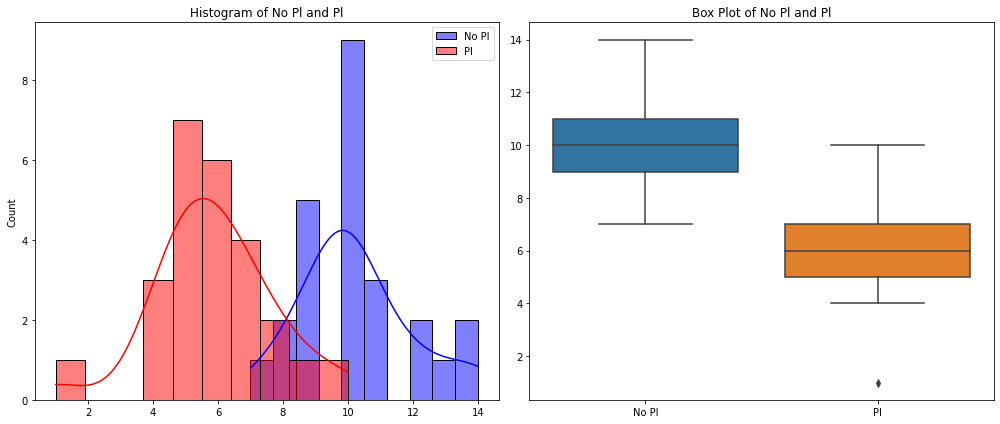

In [17]:
infraction_type = "stop_infraction"

# No Pl
inf_no_pl = df_no_pl.groupby(['model_name', 'model_number','run']).agg(['sum'])[[infraction_type]]
inf_no_pl = inf_no_pl[infraction_type]['sum'].to_list()
# Pl
inf_pl = df_pl.groupby(['model_name', 'model_number','run']).agg(['sum'])[[infraction_type]]
inf_pl = inf_pl[infraction_type]['sum'].to_list()

ttest(inf_no_pl, inf_pl, print_results=True)
plot_dist(inf_no_pl, inf_pl)

## Carla Avg Score

t-statistic: -2.8931560044771465
P-value: 0.005719056955650537
There is a significant difference!
---
No Pl: 78.37382545265514
Pl: 81.97577528170987
Improvement: -4.60%


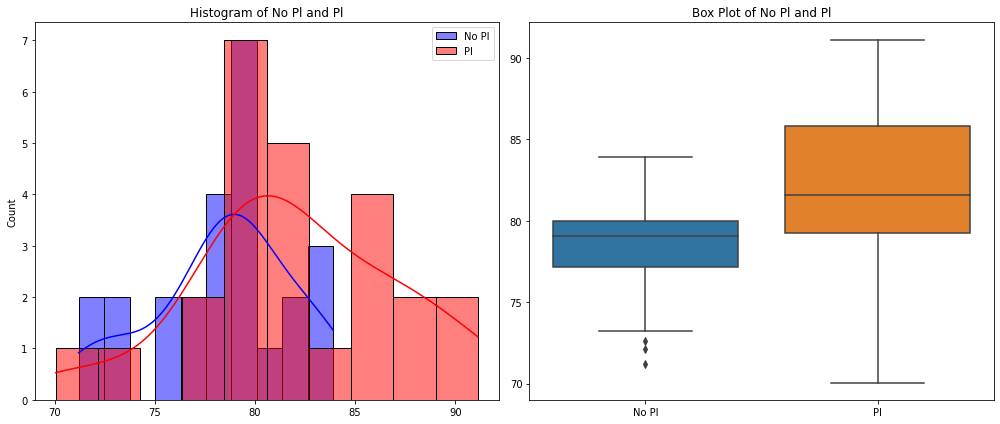

In [18]:
# No Pl
no_pl_score = df_no_pl_scores.groupby(['model_number','run']).agg(['first'])[['driving_score']]
no_pl_score = no_pl_score['driving_score']['first'].to_list()
# Pl
pl_score = df_pl_scores.groupby(['model_number','run']).agg(['first'])[['driving_score']]
pl_score = pl_score['driving_score']['first'].to_list()

ttest(no_pl_score, pl_score, print_results=True)
plot_dist(no_pl_score, pl_score)